In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
import ta  # For technical indicators
import warnings
warnings.filterwarnings("ignore")

In [52]:
df = pd.read_csv('apple_5y_stock_data.csv', skiprows=[1])
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

In [53]:
df

,Date,Close,High,Low,Open,Volume
0,2020-06-12,82.334251,84.521407,81.221236,83.772917,200146000
1,2020-06-15,83.352486,84.006203,80.822675,80.985500,138808800
2,2020-06-16,85.561531,85.833717,83.772927,85.410862,165428800
3,2020-06-17,85.442429,86.368324,85.320920,86.307569,114406400
4,2020-06-18,85.476456,85.894446,84.866480,85.398688,96820400
...,...,...,...,...,...,...
1251,2025-06-05,200.630005,204.750000,200.149994,203.500000,55126100
1252,2025-06-06,203.919998,205.699997,202.050003,203.000000,46607700
1253,2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600
1254,2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1256 non-null   object 
 1   Close   1256 non-null   float64
 2   High    1256 non-null   float64
 3   Low     1256 non-null   float64
 4   Open    1256 non-null   float64
 5   Volume  1256 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.0+ KB


In [5]:
df.describe()

,Close,High,Low,Open,Volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,164.924822,166.621580,163.048600,164.771531,8.035274e+07
std,37.835149,38.020760,37.552008,37.751238,4.166164e+07
min,82.334251,84.006203,80.822675,80.985500,2.323470e+07
25%,138.095234,139.814738,135.681677,137.834421,5.228688e+07
50%,162.848000,164.424030,161.024356,162.652276,7.027710e+07
75%,188.792259,190.112312,187.290011,188.554184,9.482710e+07
max,258.396667,259.474086,257.010028,257.568678,3.743368e+08


In [6]:
df.head(10)

,Date,Close,High,Low,Open,Volume
0,2020-06-12,82.334251,84.521407,81.221236,83.772917,200146000
1,2020-06-15,83.352486,84.006203,80.822675,80.985500,138808800
2,2020-06-16,85.561531,85.833717,83.772927,85.410862,165428800
3,2020-06-17,85.442429,86.368324,85.320920,86.307569,114406400
4,2020-06-18,85.476456,85.894446,84.866480,85.398688,96820400
5,2020-06-19,84.988014,86.650252,83.877423,86.183663,264476000
6,2020-06-22,87.211601,87.354981,85.335508,85.381682,135445200
7,2020-06-23,89.073120,90.494773,88.037864,88.458287,212155600
8,2020-06-24,87.500816,89.622360,87.126568,88.701323,192623200
9,2020-06-25,88.662415,88.701298,86.895682,87.656327,137522400


In [9]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
macd = ta.trend.MACD(close=df['Close'])
df['MACD'] = macd.macd()
boll = ta.volatility.BollingerBands(close=df['Close'])
df['BB_upper'] = boll.bollinger_hband()
df['BB_lower'] = boll.bollinger_lband()
df['Volume_change'] = df['Volume'].pct_change()
df['Close_lag1'] = df['Close'].shift(1)

In [10]:
df.dropna(inplace=True)

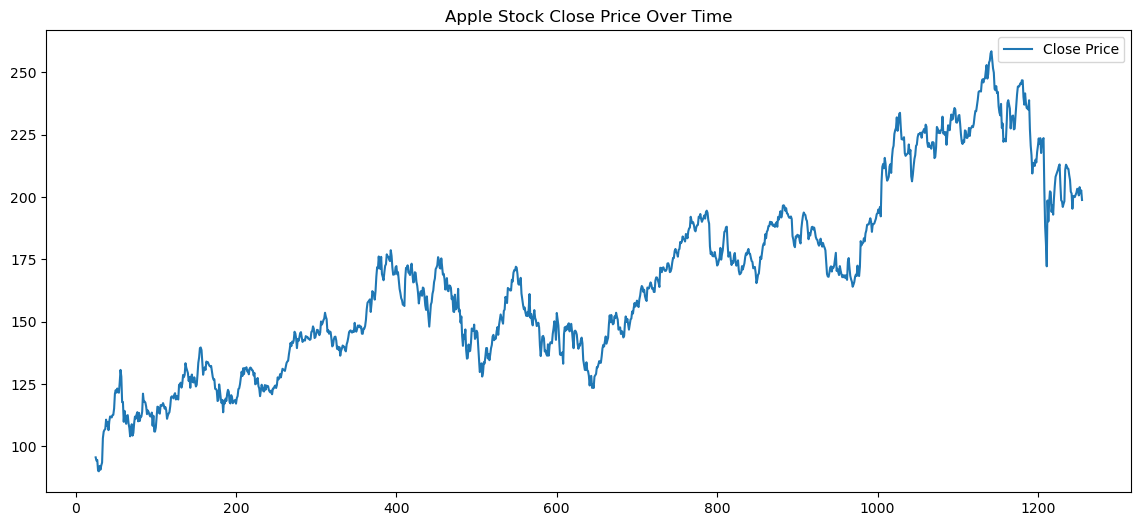

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Apple Stock Close Price Over Time')
plt.legend()
plt.show()

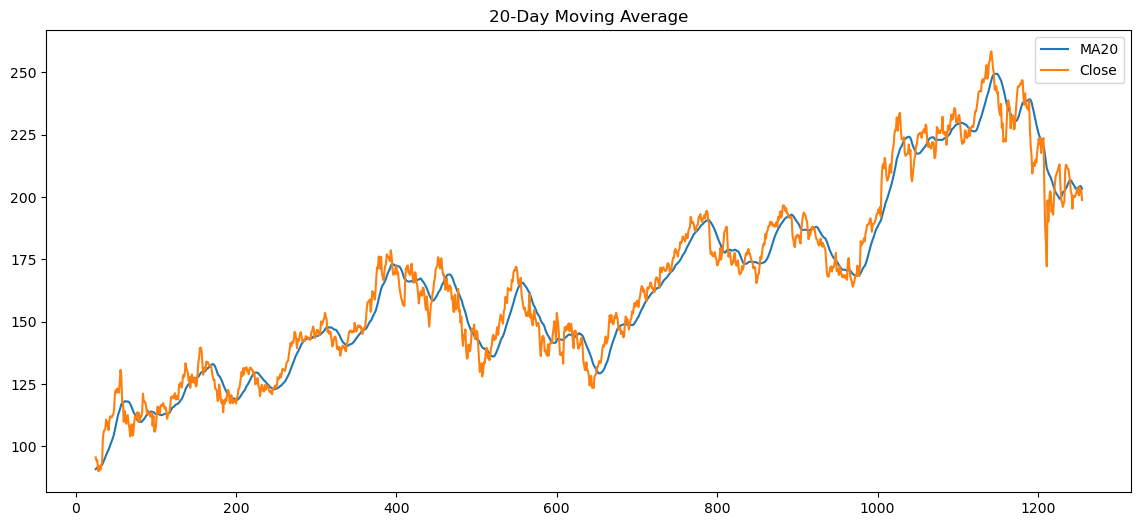

In [12]:
df[['MA20', 'Close']].plot(figsize=(14, 6), title='20-Day Moving Average')
plt.show()

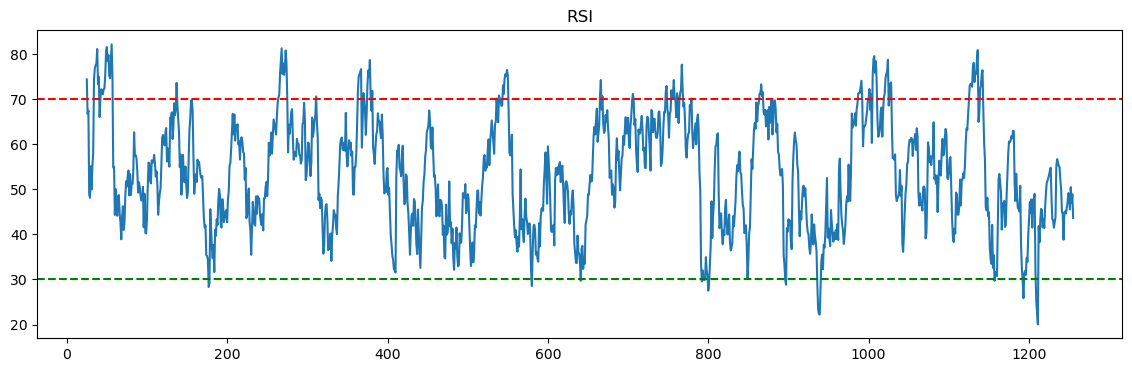

In [13]:
df['RSI'].plot(figsize=(14, 4), title='RSI')
plt.axhline(70, color='r', linestyle='--')
plt.axhline(30, color='g', linestyle='--')
plt.show()

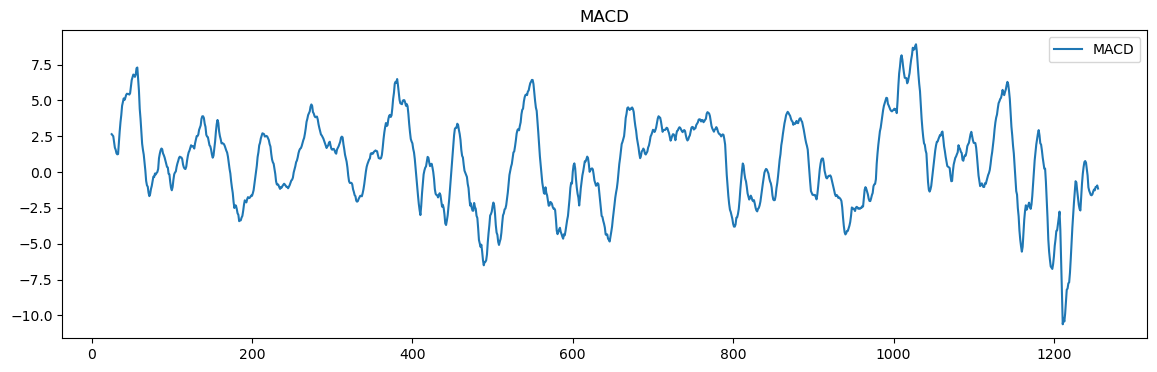

In [14]:
df[['MACD']].plot(figsize=(14, 4), title='MACD')
plt.show()

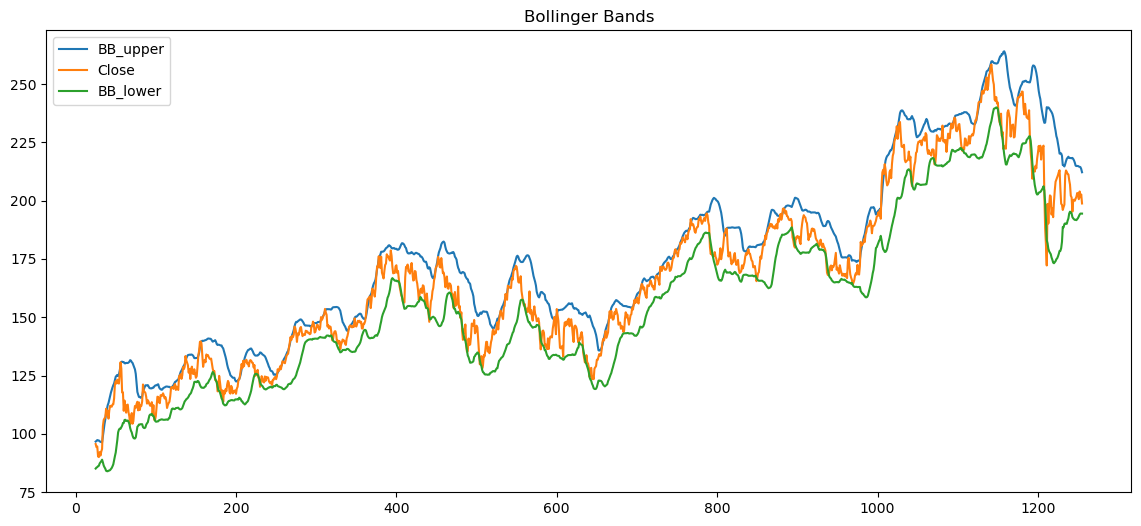

In [15]:
df[['BB_upper', 'Close', 'BB_lower']].plot(figsize=(14, 6), title='Bollinger Bands')
plt.show()

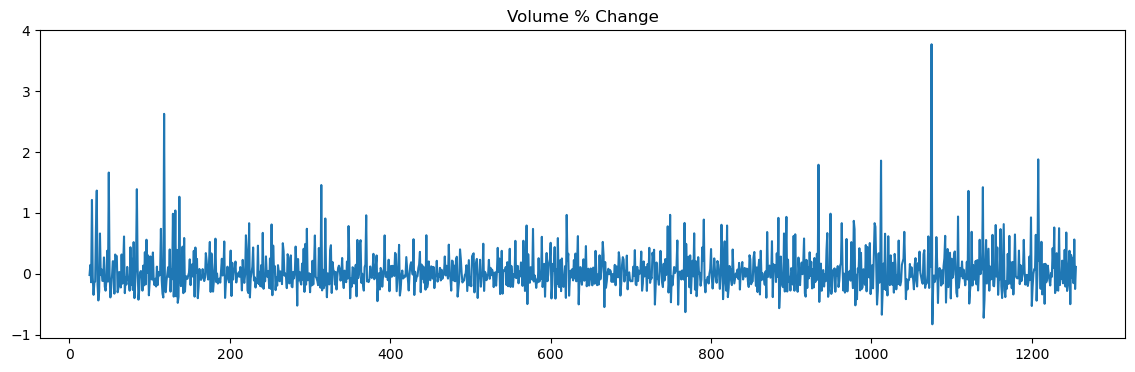

In [16]:
df['Volume_change'].plot(figsize=(14, 4), title='Volume % Change')
plt.show()

In [17]:
features = ['Open', 'High', 'Low', 'Volume', 'MA20', 'RSI', 'MACD', 'BB_upper', 'BB_lower', 'Volume_change', 'Close_lag1']
X = df[features]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [20]:
print("Linear Regression Evaluation")
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"MAE: {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²: {r2_lr:.4f}")

Linear Regression Evaluation
MAE: 1.0790
RMSE: 1.5659
R²: 0.9891


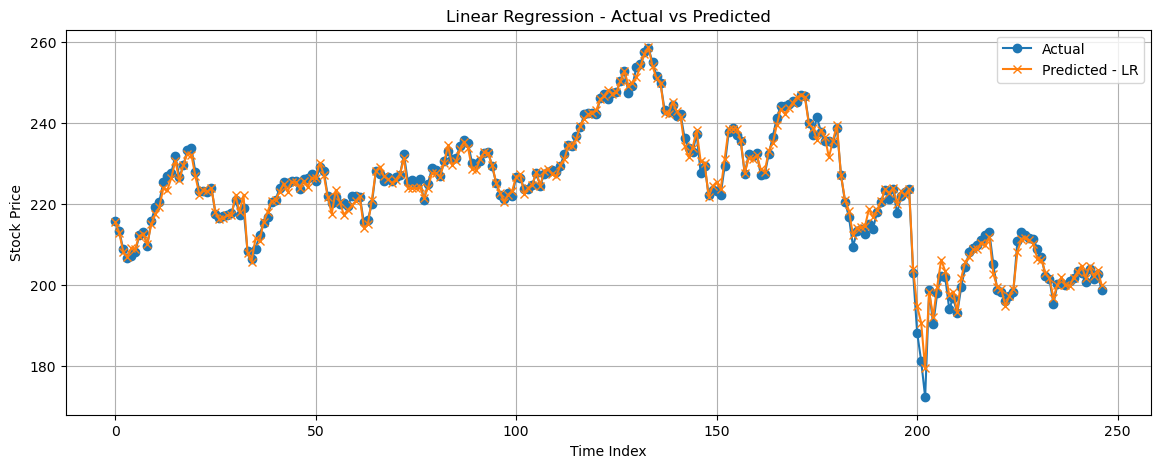

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred_lr, label='Predicted - LR', marker='x')
plt.title("Linear Regression - Actual vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [23]:
print(" Random Forest Evaluation")
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

 Random Forest Evaluation
MAE: 17.0947
RMSE: 20.8344
R²: -0.9229


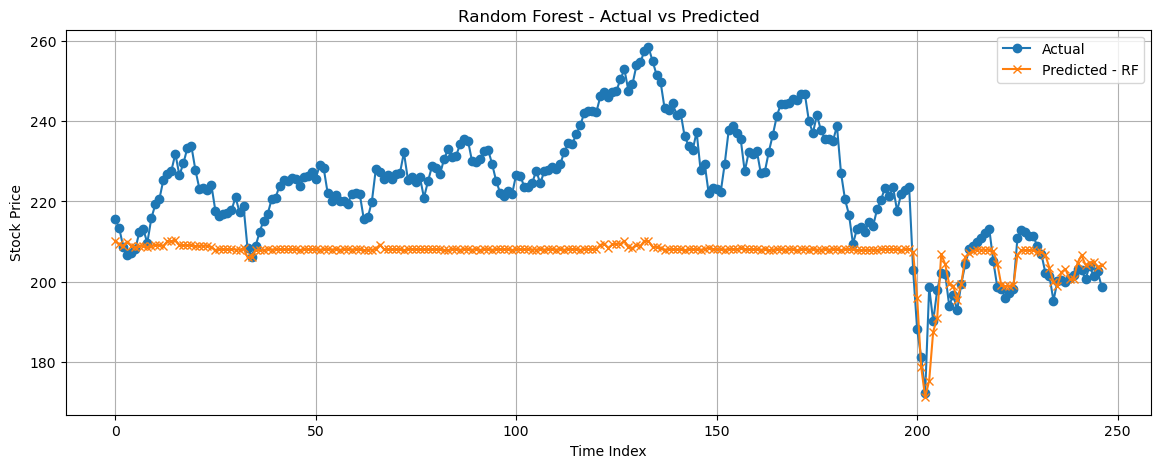

In [24]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred_rf, label='Predicted - RF', marker='x')
plt.title("Random Forest - Actual vs Predicted")
plt.xlabel("Time Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
close_data = df[['Close']]
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_data)

seq_len = 30
generator = TimeseriesGenerator(scaled_close, scaled_close, length=seq_len, batch_size=32)
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator, epochs=10, verbose=0)

lstm_input = scaled_close[-seq_len:]
lstm_input = lstm_input.reshape((1, seq_len, 1))
preds_lstm_scaled = model.predict(lstm_input)
preds_lstm = scaler.inverse_transform(preds_lstm_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [26]:
print("LSTM Evaluation (One-step ahead forecast)")
actual_close = df['Close'].values[-100:]
scaled = MinMaxScaler()
scaled_actual = scaled.fit_transform(actual_close.reshape(-1, 1))

generator = TimeseriesGenerator(scaled_actual, scaled_actual, length=30, batch_size=1)
predictions_scaled = model.predict(generator)
predictions = scaled.inverse_transform(predictions_scaled)

print(f"LSTM Predicted Last Point: {preds_lstm[0][0]:.4f}")

LSTM Evaluation (One-step ahead forecast)
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
LSTM Predicted Last Point: 205.8701


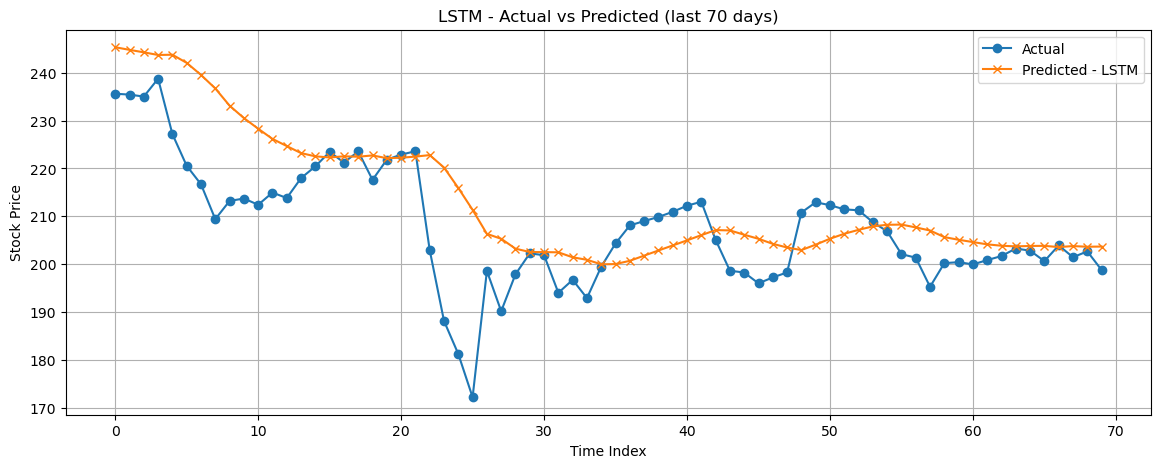

In [28]:
plt.figure(figsize=(14, 5))
plt.plot(actual_close[30:], label='Actual', marker='o')
plt.plot(predictions.flatten(), label='Predicted - LSTM', marker='x')
plt.title("LSTM - Actual vs Predicted (last 70 days)")
plt.xlabel("Time Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
model_arima = ARIMA(df['Close'], order=(5,1,0))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=5)

In [30]:
print("ARIMA Forecast for Next 5 Days")
print("Forecasted Prices:", forecast_arima.values)

ARIMA Forecast for Next 5 Days
Forecasted Prices: [198.80586199 198.67915183 198.87197821 198.98133194 199.05410195]


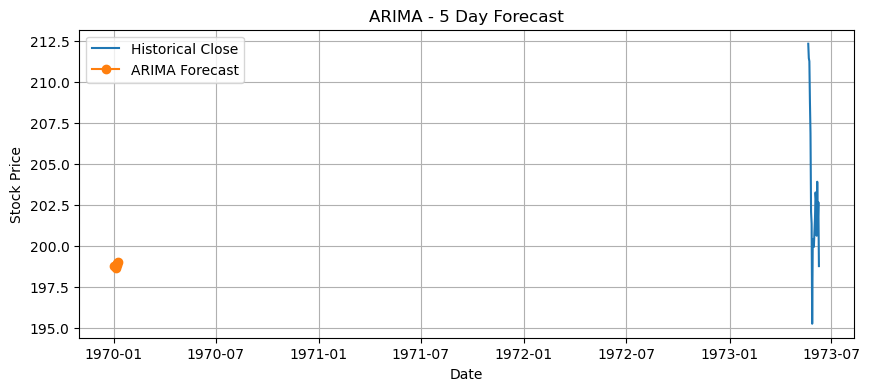

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(df['Close'].iloc[-20:], label='Historical Close')
plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='B')[1:], forecast_arima.values,
         label='ARIMA Forecast', marker='o')
plt.title("ARIMA - 5 Day Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
naive_forecast = [df['Close'].iloc[-1]] * 5

In [37]:
print("Naive Forecast")
naive_price = df['Close'].iloc[-1]


naive_forecast = [round(float(naive_price), 2)] * 5


print("Forecasted Prices:", naive_forecast)

Naive Forecast
Forecasted Prices: [198.78, 198.78, 198.78, 198.78, 198.78]


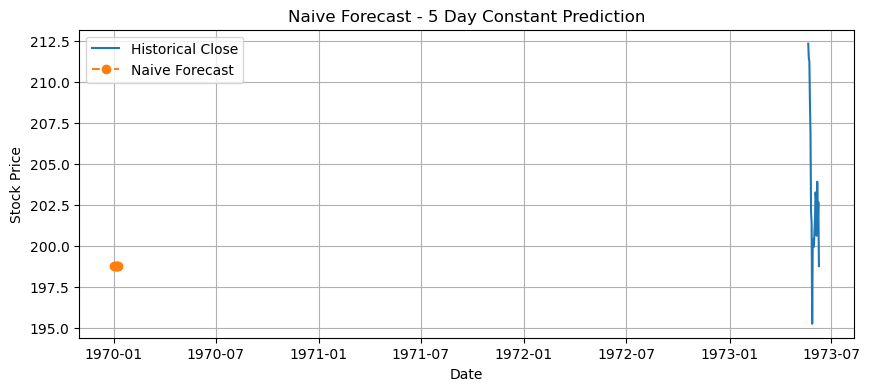

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(df['Close'].iloc[-20:], label='Historical Close')
plt.plot(pd.date_range(start=df.index[-1], periods=6, freq='B')[1:],
         [naive_price]*5, label='Naive Forecast', linestyle='--', marker='o')
plt.title("Naive Forecast - 5 Day Constant Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
last_5_X_test = X_test.tail(5)
last_5_y_true = y_test.tail(5)

last_5_X_test = X_test.tail(5)
last_5_y_true = y_test.tail(5)

# Predict using Linear Regression
last_5_pred_lr = lr.predict(last_5_X_test)

# Predict using Random Forest
last_5_pred_rf = rf.predict(last_5_X_test)

In [40]:
print(" Last 5 Days Predictions (Test Set)")
print("\nLinear Regression Predictions:")
print(np.round(last_5_pred_lr, 2))
print("\nRandom Forest Predictions:")
print(np.round(last_5_pred_rf, 2))

print("\nActual Close Prices:")
print(np.round(last_5_y_true.values, 2))

 Last 5 Days Predictions (Test Set)

Linear Regression Predictions:
[201.73 204.54 202.19 203.57 200.03]

Random Forest Predictions:
[204.17 204.68 205.   203.62 204.13]

Actual Close Prices:
[200.63 203.92 201.45 202.67 198.78]


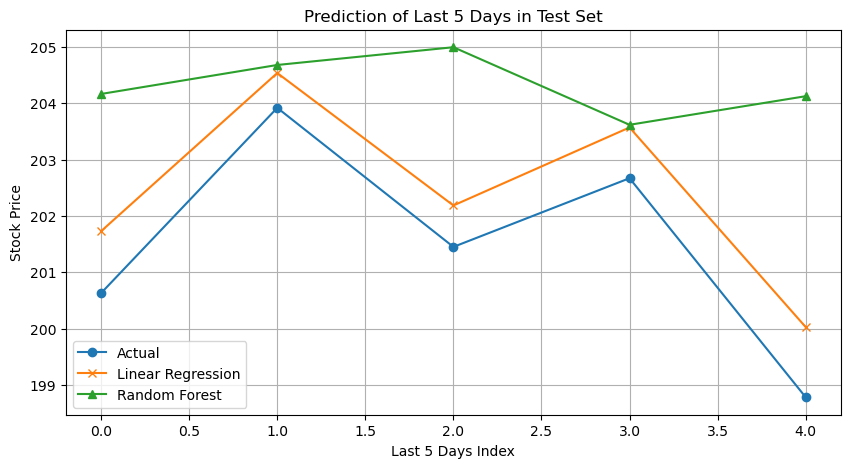

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(last_5_y_true.values, label='Actual', marker='o')
plt.plot(last_5_pred_lr, label='Linear Regression', marker='x')
plt.plot(last_5_pred_rf, label='Random Forest', marker='^')
plt.title("Prediction of Last 5 Days in Test Set")
plt.xlabel("Last 5 Days Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()